In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['fast_bowl', 'spin_bowl']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1710
Total validation images: 432
Total test images: 549
Total images in dataset: 2691


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1520
Validation images (excluding 'random_occlusion'): 384
Test images (excluding 'random_occlusion'): 488
Total images (excluding 'random_occlusion'): 2392


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'dirty_lens', 'blur', 'chromatic_aberration', 'random_occlusion', 'motion_blur', 'gaussian_noise', 'low_resolution', 'original', 'lens_flare'}
Validation folders considered: {'dirty_lens', 'blur', 'chromatic_aberration', 'random_occlusion', 'motion_blur', 'gaussian_noise', 'low_resolution', 'original', 'lens_flare'}
Test folders considered: {'dirty_lens', 'blur', 'chromatic_aberration', 'random_occlusion', 'motion_blur', 'gaussian_noise', 'low_resolution', 'original', 'lens_flare'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['fast_bowl', 'spin_bowl']
Final Training images: 1520
Final Validation images: 384
Final Test images: 488
Total images after filtering: 2392


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'dirty_lens', 'blur', 'chromatic_aberration', 'motion_blur', 'gaussian_noise', 'low_resolution', 'original', 'lens_flare'}
Validation folders considered: {'dirty_lens', 'blur', 'chromatic_aberration', 'motion_blur', 'gaussian_noise', 'low_resolution', 'original', 'lens_flare'}
Test folders considered: {'dirty_lens', 'blur', 'chromatic_aberration', 'motion_blur', 'gaussian_noise', 'low_resolution', 'original', 'lens_flare'}


In [7]:
# -----------------------------
# 2. Define DenseNet-121 Model from Scratch
# -----------------------------

class DenseLayer(nn.Module):
    """Single Dense Layer: BN-ReLU-Conv(1x1)-BN-ReLU-Conv(3x3)"""
    def __init__(self, in_channels, growth_rate=32, bn_size=4):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, bn_size * growth_rate, 
                              kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, 
                              kernel_size=3, padding=1, bias=False)
        
    def forward(self, x):
        # First convolution block
        out = F.relu(self.bn1(x))
        out = self.conv1(out)
        
        # Second convolution block
        out = F.relu(self.bn2(out))
        out = self.conv2(out)
        
        # Concatenate input with output (dense connection)
        return torch.cat([x, out], 1)

class DenseBlock(nn.Module):
    """Dense Block containing multiple Dense Layers"""
    def __init__(self, num_layers, in_channels, growth_rate=32, bn_size=4):
        super().__init__()
        self.layers = nn.ModuleList()
        
        for i in range(num_layers):
            layer = DenseLayer(in_channels + i * growth_rate, growth_rate, bn_size)
            self.layers.append(layer)
            
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class TransitionLayer(nn.Module):
    """Transition Layer: BN-ReLU-Conv(1x1)-AvgPool(2x2)"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        out = F.relu(self.bn(x))
        out = self.conv(out)
        out = self.pool(out)
        return out

class MyDenseNet121(nn.Module):
    """DenseNet-121 Implementation from Scratch"""
    def __init__(self, in_channels=3, classes=4, growth_rate=32, 
                 block_config=[6, 12, 24, 16], bn_size=4, compression_rate=0.5):
        super().__init__()
        
        # Initial convolution layer
        self.initial_conv = nn.Conv2d(in_channels, 64, kernel_size=7, 
                                     stride=2, padding=3, bias=False)
        self.initial_bn = nn.BatchNorm2d(64)
        self.initial_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Dense blocks and transition layers
        num_features = 64
        
        # Dense Block 1 + Transition 1
        self.dense_block1 = DenseBlock(block_config[0], num_features, growth_rate, bn_size)
        num_features += block_config[0] * growth_rate
        out_features = int(num_features * compression_rate)
        self.transition1 = TransitionLayer(num_features, out_features)
        num_features = out_features
        
        # Dense Block 2 + Transition 2
        self.dense_block2 = DenseBlock(block_config[1], num_features, growth_rate, bn_size)
        num_features += block_config[1] * growth_rate
        out_features = int(num_features * compression_rate)
        self.transition2 = TransitionLayer(num_features, out_features)
        num_features = out_features
        
        # Dense Block 3 + Transition 3
        self.dense_block3 = DenseBlock(block_config[2], num_features, growth_rate, bn_size)
        num_features += block_config[2] * growth_rate
        out_features = int(num_features * compression_rate)
        self.transition3 = TransitionLayer(num_features, out_features)
        num_features = out_features
        
        # Dense Block 4 (no transition after last block)
        self.dense_block4 = DenseBlock(block_config[3], num_features, growth_rate, bn_size)
        num_features += block_config[3] * growth_rate
        
        # Final layers
        self.final_bn = nn.BatchNorm2d(num_features)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(num_features, classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using He initialization for conv layers"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Initial convolution and pooling
        x = self.initial_conv(x)
        x = F.relu(self.initial_bn(x))
        x = self.initial_pool(x)
        
        # Dense blocks with transitions
        x = self.dense_block1(x)
        x = self.transition1(x)
        
        x = self.dense_block2(x)
        x = self.transition2(x)
        
        x = self.dense_block3(x)
        x = self.transition3(x)
        
        x = self.dense_block4(x)
        
        # Final classification layers
        x = F.relu(self.final_bn(x))
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        
        return x

# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyDenseNet121(3, classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("DenseNet-121 Model Summary:")
summary(model, (3, 224, 224))

DenseNet-121 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
       BatchNorm2d-4           [-1, 64, 56, 56]             128
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
            Conv2d-7           [-1, 32, 56, 56]          36,864
        DenseLayer-8           [-1, 96, 56, 56]               0
       BatchNorm2d-9           [-1, 96, 56, 56]             192
           Conv2d-10          [-1, 128, 56, 56]          12,288
      BatchNorm2d-11          [-1, 128, 56, 56]             256
           Conv2d-12           [-1, 32, 56, 56]          36,864
       DenseLayer-13          [-1, 128, 56, 56]               0
      Batch


🚀 Starting DenseNet-121 Training for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:35<00:00,  1.37it/s, Loss=0.6621, Acc=0.6112]


✅ Training completed in 35.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.15it/s, Loss=0.7169, Acc=0.5807]


✅ Validation completed in 5.58s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.5807

📊 Epoch 1 Summary:
│ Train Loss: 0.6621 | Train Acc: 0.6112
│ Val Loss:   0.7169 | Val Acc:   0.5807
│ Train Time: 35.14s | Val Time: 5.58s
│ Total Epoch Time: 40.73s
│ Best Val Acc: 0.5807 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.6154, Acc=0.6638]


✅ Training completed in 26.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.84it/s, Loss=0.9338, Acc=0.4635]


✅ Validation completed in 3.13s

📊 Epoch 2 Summary:
│ Train Loss: 0.6154 | Train Acc: 0.6638
│ Val Loss:   0.9338 | Val Acc:   0.4635
│ Train Time: 26.18s | Val Time: 3.13s
│ Total Epoch Time: 29.32s
│ Best Val Acc: 0.5807 (Epoch 1)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.81it/s, Loss=0.5959, Acc=0.6895]


✅ Training completed in 26.53s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.78it/s, Loss=0.6421, Acc=0.6979]


✅ Validation completed in 3.18s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.6979

📊 Epoch 3 Summary:
│ Train Loss: 0.5959 | Train Acc: 0.6895
│ Val Loss:   0.6421 | Val Acc:   0.6979
│ Train Time: 26.53s | Val Time: 3.18s
│ Total Epoch Time: 29.71s
│ Best Val Acc: 0.6979 (Epoch 3)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.5408, Acc=0.7296]


✅ Training completed in 26.03s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.89it/s, Loss=0.6031, Acc=0.7083]


✅ Validation completed in 3.08s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.7083

📊 Epoch 4 Summary:
│ Train Loss: 0.5408 | Train Acc: 0.7296
│ Val Loss:   0.6031 | Val Acc:   0.7083
│ Train Time: 26.03s | Val Time: 3.08s
│ Total Epoch Time: 29.13s
│ Best Val Acc: 0.7083 (Epoch 4)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.4570, Acc=0.7908]


✅ Training completed in 26.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.82it/s, Loss=0.7811, Acc=0.6797]


✅ Validation completed in 3.15s

📊 Epoch 5 Summary:
│ Train Loss: 0.4570 | Train Acc: 0.7908
│ Val Loss:   0.7811 | Val Acc:   0.6797
│ Train Time: 26.18s | Val Time: 3.15s
│ Total Epoch Time: 29.33s
│ Best Val Acc: 0.7083 (Epoch 4)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.3991, Acc=0.8171]


✅ Training completed in 26.27s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.77it/s, Loss=0.8558, Acc=0.6797]


✅ Validation completed in 3.19s

📊 Epoch 6 Summary:
│ Train Loss: 0.3991 | Train Acc: 0.8171
│ Val Loss:   0.8558 | Val Acc:   0.6797
│ Train Time: 26.27s | Val Time: 3.19s
│ Total Epoch Time: 29.46s
│ Best Val Acc: 0.7083 (Epoch 4)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.3419, Acc=0.8533]


✅ Training completed in 26.17s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.72it/s, Loss=1.0202, Acc=0.5625]


✅ Validation completed in 3.23s

📊 Epoch 7 Summary:
│ Train Loss: 0.3419 | Train Acc: 0.8533
│ Val Loss:   1.0202 | Val Acc:   0.5625
│ Train Time: 26.17s | Val Time: 3.23s
│ Total Epoch Time: 29.40s
│ Best Val Acc: 0.7083 (Epoch 4)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.2445, Acc=0.9092]


✅ Training completed in 26.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.86it/s, Loss=1.0042, Acc=0.7240]


✅ Validation completed in 3.11s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.7240

📊 Epoch 8 Summary:
│ Train Loss: 0.2445 | Train Acc: 0.9092
│ Val Loss:   1.0042 | Val Acc:   0.7240
│ Train Time: 26.18s | Val Time: 3.11s
│ Total Epoch Time: 29.30s
│ Best Val Acc: 0.7240 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.2056, Acc=0.9257]


✅ Training completed in 26.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.79it/s, Loss=1.0548, Acc=0.6198]


✅ Validation completed in 3.17s

📊 Epoch 9 Summary:
│ Train Loss: 0.2056 | Train Acc: 0.9257
│ Val Loss:   1.0548 | Val Acc:   0.6198
│ Train Time: 26.18s | Val Time: 3.17s
│ Total Epoch Time: 29.35s
│ Best Val Acc: 0.7240 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.1924, Acc=0.9217]


✅ Training completed in 26.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.83it/s, Loss=1.1655, Acc=0.6042]


✅ Validation completed in 3.13s

📊 Epoch 10 Summary:
│ Train Loss: 0.1924 | Train Acc: 0.9217
│ Val Loss:   1.1655 | Val Acc:   0.6042
│ Train Time: 26.11s | Val Time: 3.13s
│ Total Epoch Time: 29.25s
│ Best Val Acc: 0.7240 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.1844, Acc=0.9309]


✅ Training completed in 26.10s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.79it/s, Loss=1.1438, Acc=0.6979]


✅ Validation completed in 3.17s

📊 Epoch 11 Summary:
│ Train Loss: 0.1844 | Train Acc: 0.9309
│ Val Loss:   1.1438 | Val Acc:   0.6979
│ Train Time: 26.10s | Val Time: 3.17s
│ Total Epoch Time: 29.27s
│ Best Val Acc: 0.7240 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.1617, Acc=0.9388]


✅ Training completed in 26.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.80it/s, Loss=1.2549, Acc=0.6016]


✅ Validation completed in 3.16s

📊 Epoch 12 Summary:
│ Train Loss: 0.1617 | Train Acc: 0.9388
│ Val Loss:   1.2549 | Val Acc:   0.6016
│ Train Time: 26.13s | Val Time: 3.16s
│ Total Epoch Time: 29.29s
│ Best Val Acc: 0.7240 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.0996, Acc=0.9658]


✅ Training completed in 26.04s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.78it/s, Loss=1.2732, Acc=0.6302]


✅ Validation completed in 3.17s

📊 Epoch 13 Summary:
│ Train Loss: 0.0996 | Train Acc: 0.9658
│ Val Loss:   1.2732 | Val Acc:   0.6302
│ Train Time: 26.04s | Val Time: 3.17s
│ Total Epoch Time: 29.22s
│ Best Val Acc: 0.7240 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.1460, Acc=0.9428]


✅ Training completed in 26.10s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.87it/s, Loss=1.1407, Acc=0.6510]


✅ Validation completed in 3.11s

📊 Epoch 14 Summary:
│ Train Loss: 0.1460 | Train Acc: 0.9428
│ Val Loss:   1.1407 | Val Acc:   0.6510
│ Train Time: 26.10s | Val Time: 3.11s
│ Total Epoch Time: 29.21s
│ Best Val Acc: 0.7240 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.82it/s, Loss=0.1601, Acc=0.9395]


✅ Training completed in 26.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.72it/s, Loss=1.2388, Acc=0.6927]


✅ Validation completed in 3.23s

📊 Epoch 15 Summary:
│ Train Loss: 0.1601 | Train Acc: 0.9395
│ Val Loss:   1.2388 | Val Acc:   0.6927
│ Train Time: 26.34s | Val Time: 3.23s
│ Total Epoch Time: 29.57s
│ Best Val Acc: 0.7240 (Epoch 8)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.85it/s, Loss=0.1127, Acc=0.9572]


✅ Training completed in 25.99s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.66it/s, Loss=1.0335, Acc=0.7344]


✅ Validation completed in 3.28s
🌟 New best DenseNet-121 model found! Validation Accuracy: 0.7344

📊 Epoch 16 Summary:
│ Train Loss: 0.1127 | Train Acc: 0.9572
│ Val Loss:   1.0335 | Val Acc:   0.7344
│ Train Time: 25.99s | Val Time: 3.28s
│ Total Epoch Time: 29.28s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0676, Acc=0.9697]


✅ Training completed in 26.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.74it/s, Loss=1.2615, Acc=0.6328]


✅ Validation completed in 3.21s

📊 Epoch 17 Summary:
│ Train Loss: 0.0676 | Train Acc: 0.9697
│ Val Loss:   1.2615 | Val Acc:   0.6328
│ Train Time: 26.29s | Val Time: 3.21s
│ Total Epoch Time: 29.51s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.85it/s, Loss=0.0442, Acc=0.9882]


✅ Training completed in 25.92s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.79it/s, Loss=1.5751, Acc=0.6224]


✅ Validation completed in 3.17s

📊 Epoch 18 Summary:
│ Train Loss: 0.0442 | Train Acc: 0.9882
│ Val Loss:   1.5751 | Val Acc:   0.6224
│ Train Time: 25.92s | Val Time: 3.17s
│ Total Epoch Time: 29.09s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.0386, Acc=0.9882]


✅ Training completed in 26.06s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.79it/s, Loss=1.8829, Acc=0.6172]


✅ Validation completed in 3.17s

📊 Epoch 19 Summary:
│ Train Loss: 0.0386 | Train Acc: 0.9882
│ Val Loss:   1.8829 | Val Acc:   0.6172
│ Train Time: 26.06s | Val Time: 3.17s
│ Total Epoch Time: 29.23s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.0708, Acc=0.9789]


✅ Training completed in 26.06s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.79it/s, Loss=1.4974, Acc=0.6797]


✅ Validation completed in 3.17s

📊 Epoch 20 Summary:
│ Train Loss: 0.0708 | Train Acc: 0.9789
│ Val Loss:   1.4974 | Val Acc:   0.6797
│ Train Time: 26.06s | Val Time: 3.17s
│ Total Epoch Time: 29.23s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.82it/s, Loss=0.0962, Acc=0.9671]


✅ Training completed in 26.32s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.74it/s, Loss=1.4398, Acc=0.6667]


✅ Validation completed in 3.21s

📊 Epoch 21 Summary:
│ Train Loss: 0.0962 | Train Acc: 0.9671
│ Val Loss:   1.4398 | Val Acc:   0.6667
│ Train Time: 26.32s | Val Time: 3.21s
│ Total Epoch Time: 29.53s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0551, Acc=0.9836]


✅ Training completed in 26.26s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.83it/s, Loss=1.8683, Acc=0.6432]


✅ Validation completed in 3.14s

📊 Epoch 22 Summary:
│ Train Loss: 0.0551 | Train Acc: 0.9836
│ Val Loss:   1.8683 | Val Acc:   0.6432
│ Train Time: 26.26s | Val Time: 3.14s
│ Total Epoch Time: 29.40s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0569, Acc=0.9776]


✅ Training completed in 26.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.76it/s, Loss=1.9729, Acc=0.6354]


✅ Validation completed in 3.19s

📊 Epoch 23 Summary:
│ Train Loss: 0.0569 | Train Acc: 0.9776
│ Val Loss:   1.9729 | Val Acc:   0.6354
│ Train Time: 26.19s | Val Time: 3.19s
│ Total Epoch Time: 29.38s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0200, Acc=0.9954]


✅ Training completed in 26.26s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.86it/s, Loss=1.9287, Acc=0.6276]


✅ Validation completed in 3.11s

📊 Epoch 24 Summary:
│ Train Loss: 0.0200 | Train Acc: 0.9954
│ Val Loss:   1.9287 | Val Acc:   0.6276
│ Train Time: 26.26s | Val Time: 3.11s
│ Total Epoch Time: 29.37s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0217, Acc=0.9921]


✅ Training completed in 26.26s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.84it/s, Loss=1.8768, Acc=0.7109]


✅ Validation completed in 3.13s

📊 Epoch 25 Summary:
│ Train Loss: 0.0217 | Train Acc: 0.9921
│ Val Loss:   1.8768 | Val Acc:   0.7109
│ Train Time: 26.26s | Val Time: 3.13s
│ Total Epoch Time: 29.39s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0355, Acc=0.9882]


✅ Training completed in 26.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.84it/s, Loss=1.7378, Acc=0.7083]


✅ Validation completed in 3.13s

📊 Epoch 26 Summary:
│ Train Loss: 0.0355 | Train Acc: 0.9882
│ Val Loss:   1.7378 | Val Acc:   0.7083
│ Train Time: 26.18s | Val Time: 3.13s
│ Total Epoch Time: 29.31s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0244, Acc=0.9928]


✅ Training completed in 26.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.71it/s, Loss=1.8416, Acc=0.6198]


✅ Validation completed in 3.23s

📊 Epoch 27 Summary:
│ Train Loss: 0.0244 | Train Acc: 0.9928
│ Val Loss:   1.8416 | Val Acc:   0.6198
│ Train Time: 26.18s | Val Time: 3.23s
│ Total Epoch Time: 29.42s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.0507, Acc=0.9829]


✅ Training completed in 26.12s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.75it/s, Loss=1.5052, Acc=0.6693]


✅ Validation completed in 3.21s

📊 Epoch 28 Summary:
│ Train Loss: 0.0507 | Train Acc: 0.9829
│ Val Loss:   1.5052 | Val Acc:   0.6693
│ Train Time: 26.12s | Val Time: 3.21s
│ Total Epoch Time: 29.33s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.80it/s, Loss=0.0687, Acc=0.9763]


✅ Training completed in 26.62s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.77it/s, Loss=1.7154, Acc=0.6172]


✅ Validation completed in 3.18s

📊 Epoch 29 Summary:
│ Train Loss: 0.0687 | Train Acc: 0.9763
│ Val Loss:   1.7154 | Val Acc:   0.6172
│ Train Time: 26.62s | Val Time: 3.18s
│ Total Epoch Time: 29.81s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0788, Acc=0.9737]


✅ Training completed in 26.24s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.79it/s, Loss=1.8234, Acc=0.5964]


✅ Validation completed in 3.17s

📊 Epoch 30 Summary:
│ Train Loss: 0.0788 | Train Acc: 0.9737
│ Val Loss:   1.8234 | Val Acc:   0.5964
│ Train Time: 26.24s | Val Time: 3.17s
│ Total Epoch Time: 29.41s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.1044, Acc=0.9691]


✅ Training completed in 26.03s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.84it/s, Loss=1.5013, Acc=0.6224]


✅ Validation completed in 3.13s

📊 Epoch 31 Summary:
│ Train Loss: 0.1044 | Train Acc: 0.9691
│ Val Loss:   1.5013 | Val Acc:   0.6224
│ Train Time: 26.03s | Val Time: 3.13s
│ Total Epoch Time: 29.16s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0418, Acc=0.9862]


✅ Training completed in 26.16s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.85it/s, Loss=1.3926, Acc=0.7005]


✅ Validation completed in 3.12s

📊 Epoch 32 Summary:
│ Train Loss: 0.0418 | Train Acc: 0.9862
│ Val Loss:   1.3926 | Val Acc:   0.7005
│ Train Time: 26.16s | Val Time: 3.12s
│ Total Epoch Time: 29.29s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:25<00:00,  1.85it/s, Loss=0.0437, Acc=0.9868]


✅ Training completed in 25.95s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.73it/s, Loss=1.7889, Acc=0.6406]


✅ Validation completed in 3.22s

📊 Epoch 33 Summary:
│ Train Loss: 0.0437 | Train Acc: 0.9868
│ Val Loss:   1.7889 | Val Acc:   0.6406
│ Train Time: 25.95s | Val Time: 3.22s
│ Total Epoch Time: 29.17s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.0384, Acc=0.9875]


✅ Training completed in 26.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.80it/s, Loss=1.8168, Acc=0.6667]


✅ Validation completed in 3.16s

📊 Epoch 34 Summary:
│ Train Loss: 0.0384 | Train Acc: 0.9875
│ Val Loss:   1.8168 | Val Acc:   0.6667
│ Train Time: 26.07s | Val Time: 3.16s
│ Total Epoch Time: 29.24s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.0162, Acc=0.9954]


✅ Training completed in 26.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.87it/s, Loss=1.9300, Acc=0.6198]


✅ Validation completed in 3.10s

📊 Epoch 35 Summary:
│ Train Loss: 0.0162 | Train Acc: 0.9954
│ Val Loss:   1.9300 | Val Acc:   0.6198
│ Train Time: 26.11s | Val Time: 3.10s
│ Total Epoch Time: 29.22s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0101, Acc=0.9974]


✅ Training completed in 26.28s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.77it/s, Loss=2.0015, Acc=0.6380]


✅ Validation completed in 3.18s

📊 Epoch 36 Summary:
│ Train Loss: 0.0101 | Train Acc: 0.9974
│ Val Loss:   2.0015 | Val Acc:   0.6380
│ Train Time: 26.28s | Val Time: 3.18s
│ Total Epoch Time: 29.47s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.0105, Acc=0.9967]


✅ Training completed in 26.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.63it/s, Loss=2.0900, Acc=0.6328]


✅ Validation completed in 3.31s

📊 Epoch 37 Summary:
│ Train Loss: 0.0105 | Train Acc: 0.9967
│ Val Loss:   2.0900 | Val Acc:   0.6328
│ Train Time: 26.13s | Val Time: 3.31s
│ Total Epoch Time: 29.44s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0444, Acc=0.9888]


✅ Training completed in 26.24s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.77it/s, Loss=1.9404, Acc=0.5885]


✅ Validation completed in 3.19s

📊 Epoch 38 Summary:
│ Train Loss: 0.0444 | Train Acc: 0.9888
│ Val Loss:   1.9404 | Val Acc:   0.5885
│ Train Time: 26.24s | Val Time: 3.19s
│ Total Epoch Time: 29.44s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.0374, Acc=0.9914]


✅ Training completed in 26.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.73it/s, Loss=1.7697, Acc=0.6562]


✅ Validation completed in 3.22s

📊 Epoch 39 Summary:
│ Train Loss: 0.0374 | Train Acc: 0.9914
│ Val Loss:   1.7697 | Val Acc:   0.6562
│ Train Time: 26.14s | Val Time: 3.22s
│ Total Epoch Time: 29.37s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0944, Acc=0.9730]


✅ Training completed in 26.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.87it/s, Loss=1.7926, Acc=0.6458]


✅ Validation completed in 3.10s

📊 Epoch 40 Summary:
│ Train Loss: 0.0944 | Train Acc: 0.9730
│ Val Loss:   1.7926 | Val Acc:   0.6458
│ Train Time: 26.29s | Val Time: 3.10s
│ Total Epoch Time: 29.40s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0601, Acc=0.9757]


✅ Training completed in 26.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.83it/s, Loss=1.4978, Acc=0.6536]


✅ Validation completed in 3.14s

📊 Epoch 41 Summary:
│ Train Loss: 0.0601 | Train Acc: 0.9757
│ Val Loss:   1.4978 | Val Acc:   0.6536
│ Train Time: 26.29s | Val Time: 3.14s
│ Total Epoch Time: 29.43s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0322, Acc=0.9875]


✅ Training completed in 26.28s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.86it/s, Loss=1.7278, Acc=0.6953]


✅ Validation completed in 3.11s

📊 Epoch 42 Summary:
│ Train Loss: 0.0322 | Train Acc: 0.9875
│ Val Loss:   1.7278 | Val Acc:   0.6953
│ Train Time: 26.28s | Val Time: 3.11s
│ Total Epoch Time: 29.39s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.0082, Acc=0.9993]


✅ Training completed in 26.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.83it/s, Loss=1.5733, Acc=0.7083]


✅ Validation completed in 3.13s

📊 Epoch 43 Summary:
│ Train Loss: 0.0082 | Train Acc: 0.9993
│ Val Loss:   1.5733 | Val Acc:   0.7083
│ Train Time: 26.07s | Val Time: 3.13s
│ Total Epoch Time: 29.21s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0094, Acc=0.9974]


✅ Training completed in 26.23s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.82it/s, Loss=1.6954, Acc=0.6849]


✅ Validation completed in 3.14s

📊 Epoch 44 Summary:
│ Train Loss: 0.0094 | Train Acc: 0.9974
│ Val Loss:   1.6954 | Val Acc:   0.6849
│ Train Time: 26.23s | Val Time: 3.14s
│ Total Epoch Time: 29.38s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.0078, Acc=0.9974]


✅ Training completed in 26.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.77it/s, Loss=1.9855, Acc=0.6615]


✅ Validation completed in 3.18s

📊 Epoch 45 Summary:
│ Train Loss: 0.0078 | Train Acc: 0.9974
│ Val Loss:   1.9855 | Val Acc:   0.6615
│ Train Time: 26.11s | Val Time: 3.18s
│ Total Epoch Time: 29.30s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0113, Acc=0.9974]


✅ Training completed in 26.27s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.82it/s, Loss=1.7852, Acc=0.6797]


✅ Validation completed in 3.15s

📊 Epoch 46 Summary:
│ Train Loss: 0.0113 | Train Acc: 0.9974
│ Val Loss:   1.7852 | Val Acc:   0.6797
│ Train Time: 26.27s | Val Time: 3.15s
│ Total Epoch Time: 29.42s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.0151, Acc=0.9947]


✅ Training completed in 26.16s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.74it/s, Loss=1.6477, Acc=0.7083]


✅ Validation completed in 3.21s

📊 Epoch 47 Summary:
│ Train Loss: 0.0151 | Train Acc: 0.9947
│ Val Loss:   1.6477 | Val Acc:   0.7083
│ Train Time: 26.16s | Val Time: 3.21s
│ Total Epoch Time: 29.38s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.82it/s, Loss=0.0267, Acc=0.9914]


✅ Training completed in 26.43s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.77it/s, Loss=1.9435, Acc=0.6536]


✅ Validation completed in 3.18s

📊 Epoch 48 Summary:
│ Train Loss: 0.0267 | Train Acc: 0.9914
│ Val Loss:   1.9435 | Val Acc:   0.6536
│ Train Time: 26.43s | Val Time: 3.18s
│ Total Epoch Time: 29.62s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.84it/s, Loss=0.0136, Acc=0.9954]


✅ Training completed in 26.15s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.83it/s, Loss=1.8700, Acc=0.6693]


✅ Validation completed in 3.13s

📊 Epoch 49 Summary:
│ Train Loss: 0.0136 | Train Acc: 0.9954
│ Val Loss:   1.8700 | Val Acc:   0.6693
│ Train Time: 26.15s | Val Time: 3.13s
│ Total Epoch Time: 29.29s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:26<00:00,  1.83it/s, Loss=0.0085, Acc=0.9974]


✅ Training completed in 26.28s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:03<00:00,  3.79it/s, Loss=2.1315, Acc=0.6693]


✅ Validation completed in 3.17s

📊 Epoch 50 Summary:
│ Train Loss: 0.0085 | Train Acc: 0.9974
│ Val Loss:   2.1315 | Val Acc:   0.6693
│ Train Time: 26.28s | Val Time: 3.17s
│ Total Epoch Time: 29.45s
│ Best Val Acc: 0.7344 (Epoch 16)
│ GPU Memory: 0.1GB / 4.5GB

💾 Best DenseNet-121 model saved as 'best_densenet121_model.pth'
📊 Best model stats:
│ Best Epoch: 16
│ Best Val Acc: 0.7344

💾 DenseNet-121 training history saved to 'densenet121_training_history.csv'

🎉 DenseNet-121 Training Complete!
Total Training Time: 1479.34s (24.7 minutes)
Average Epoch Time: 29.59s

⏱️  Epoch Timing Breakdown:
│ Epoch 1: 40.73s
│ Epoch 2: 29.32s
│ Epoch 3: 29.71s
│ Epoch 4: 29.13s
│ Epoch 5: 29.33s
│ Epoch 6: 29.46s
│ Epoch 7: 29.40s
│ Epoch 8: 29.30s
│ Epoch 9: 29.35s
│ Epoch 10: 29.25s
│ Epoch 11: 29.27s
│ Epoch 12: 29.29s
│ Epoch 13: 29.22s
│ Epoch 14: 29.21s
│ Epoch 15: 29.57s
│ Epoch 16: 29.28s
│ Epoch 17: 29.51s
│ Epoch 18: 29.09s
│ Epoch 19: 29.23s
│ Epoch 20: 29.23s
│ Epoch 21: 29.53s
│ Epoch 2

Testing DenseNet-121: 100%|██████████████████████████████| 16/16 [00:07<00:00,  2.08it/s]


✅ DenseNet-121 Testing completed in 7.71s

📋 DenseNet-121 Classification Report:
              precision    recall  f1-score   support

   fast_bowl       0.73      0.75      0.74       304
   spin_bowl       0.56      0.54      0.55       184

    accuracy                           0.67       488
   macro avg       0.65      0.64      0.64       488
weighted avg       0.67      0.67      0.67       488

🎯 DenseNet-121 Test Accuracy: 0.6680

📊 DenseNet-121 Model Performance Summary:
│ Best Validation Acc:  0.7344 (Epoch 16)
│ Final Test Accuracy:  0.6680
│ Val-Test Gap:         0.0663


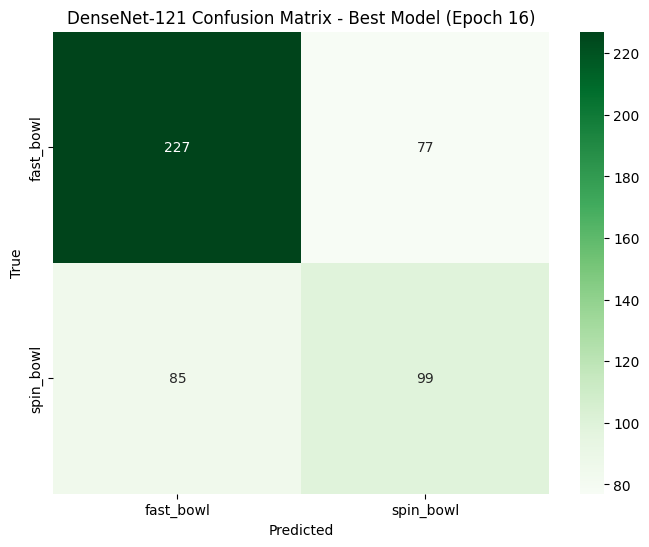

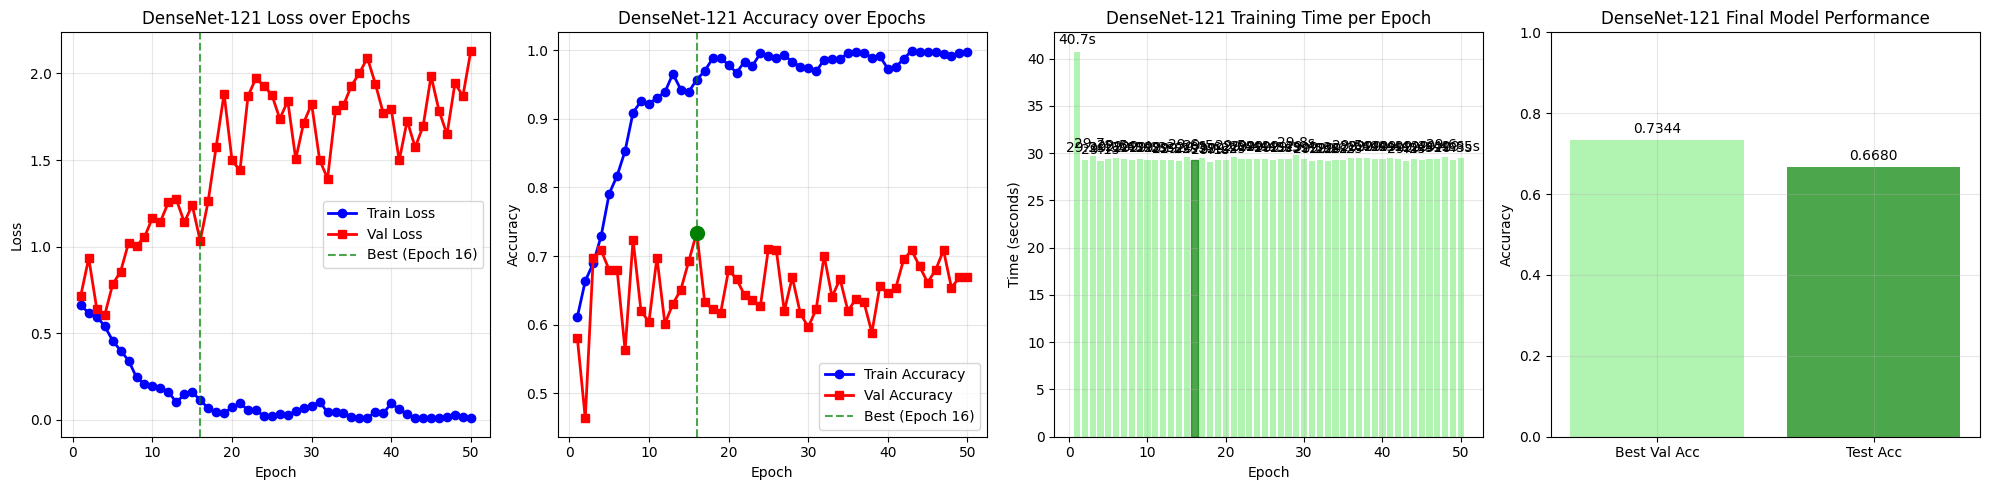


⏰ DenseNet-121 Final Timing Summary:
│ Total Training: 1479.34s
│ Average per Epoch: 29.59s
│ Testing Time: 7.71s
│ Total Runtime: 1487.05s

💾 DenseNet-121 Files saved:
│ best_densenet121_model.pth - Best validation accuracy model
│ densenet121_training_history.csv - Training metrics for later plotting


In [8]:
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - DenseNet-121
# -----------------------------
import pandas as pd
from tqdm import tqdm
import time

train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking - CHANGED TO VAL_ACC
best_val_acc = 0.0  # Changed from best_val_loss = float('inf')
best_model_state = None
best_epoch = 0

print(f"\n🚀 Starting DenseNet-121 Training for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc - CHANGED
    is_best = val_acc > best_val_acc  # Changed from val_loss < best_val_loss
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best DenseNet-121 model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")  # Changed
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model - UPDATED MESSAGES
if best_model_state is not None:
    torch.save(best_model_state, 'best_densenet121_model.pth')
    print(f"\n💾 Best DenseNet-121 model saved as 'best_densenet121_model.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")  # Changed from best_val_loss

# NEW: Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('densenet121_training_history.csv', index=False)
print("\n💾 DenseNet-121 training history saved to 'densenet121_training_history.csv'")

# Training Summary
print(f"\n🎉 DenseNet-121 Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n⏱️  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"│ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best DenseNet-121 Model for Testing...")
# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best DenseNet-121 model from epoch {best_epoch} loaded successfully!")
else:
    print("⚠️  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing DenseNet-121", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ DenseNet-121 Testing completed in {test_time:.2f}s")
print("\n📋 DenseNet-121 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 DenseNet-121 Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary - UPDATED
print(f"\n📊 DenseNet-121 Model Performance Summary:")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")  # Changed
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"DenseNet-121 Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations - UPDATED
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("DenseNet-121 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot - UPDATED
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)  # Changed to best_val_acc
plt.legend()
plt.title("DenseNet-121 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='lightgreen', alpha=0.7)
bars[best_epoch-1].set_color('green')
plt.title("DenseNet-121 Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['lightgreen', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("DenseNet-121 Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n⏰ DenseNet-121 Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\n💾 DenseNet-121 Files saved:")
print(f"│ best_densenet121_model.pth - Best validation accuracy model")
print(f"│ densenet121_training_history.csv - Training metrics for later plotting")

In [9]:
import pandas as pd
df=pd.read_csv("/kaggle/working/densenet121_training_history.csv")
df

,epoch,train_loss,val_loss,train_acc,val_acc,epoch_time
0,1,0.662077,0.716904,0.611184,0.580729,40.731831
1,2,0.615433,0.933767,0.663816,0.463542,29.316214
2,3,0.595912,0.642131,0.689474,0.697917,29.711928
3,4,0.540821,0.603096,0.729605,0.708333,29.126153
4,5,0.456970,0.781136,0.790789,0.679688,29.328840
5,6,0.399144,0.855798,0.817105,0.679688,29.463019
6,7,0.341878,1.020223,0.853289,0.562500,29.402977
7,8,0.244490,1.004234,0.909211,0.723958,29.298037
8,9,0.205643,1.054777,0.925658,0.619792,29.354836
9,10,0.192359,1.165473,0.921711,0.604167,29.245620
